### 3.4 Clustering

Python program to evaluate performance using clustering on the datasets obtained in Task 3.1.

In [262]:
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import adjusted_rand_score

%load_ext autoreload
%autoreload 2

import bamboo.gwp_pipeline as gwp
import bamboo.star_pipeline as star
from bamboo.processing import read_csv, split_features_and_target, get_feature_and_target_names
from bamboo.analysis import *
from bamboo.selection import normalize_data, normalize_train_test, filter_features
from bamboo.clustering import *

SEED = 42

GWP_CSV = 'datasets/gwp_assessment.csv'
STAR_CSV = 'datasets/star_assessment.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Preperation
Repeated steps to initialisze gwp & star datasets to be passed to models just like in task3_2.ipynb

In [263]:
# ------ GWP ------ #
# Load and process from csv
gwp_data = read_csv(GWP_CSV)
gwp_dataset = gwp.gwp_pipeline(gwp_data, seed=SEED)

# Split features and target and filter features
X_gwp, y_gwp = split_features_and_target(gwp_dataset)
X_gwp_names, y_gwp_name = get_feature_and_target_names(gwp_dataset)
X_gwp, X_gwp_names = filter_features(X_gwp, y_gwp, X_gwp_names, corr_coef=0.05, const_coef=0.01)

# Normalize data
X_gwp = normalize_data(X_gwp)

# ------ STAR ------ #
# Load and process Star from csv
star_data = read_csv(STAR_CSV)
star_dataset = star.star_pipeline(star_data, seed=SEED)

# Split features and target and filter features
X_star, y_star = split_features_and_target(star_dataset)
X_star_names, y_star_name = get_feature_and_target_names(star_dataset)
X_star, X_star_names = filter_features(X_star, y_star, X_star_names, corr_coef=0.01, const_coef=0.01)

# Split into training and testing sets since it is classification problem
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, test_size=0.2, random_state=SEED)

# Normalize data
X_star_train, X_star_test = normalize_train_test(X_star_train, X_star_test)

/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nickolaitchesnokov/Desktop/Code/Projects/data_mining/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## GWP Clustering

### K-means: Elbow method & Silhouette coefficient
From the plots below:
- "Elbow" point = 2 clusters.
- Highest coefficient point = 2 clusters

Optimum number of clusters for GWP data seems to be 2.


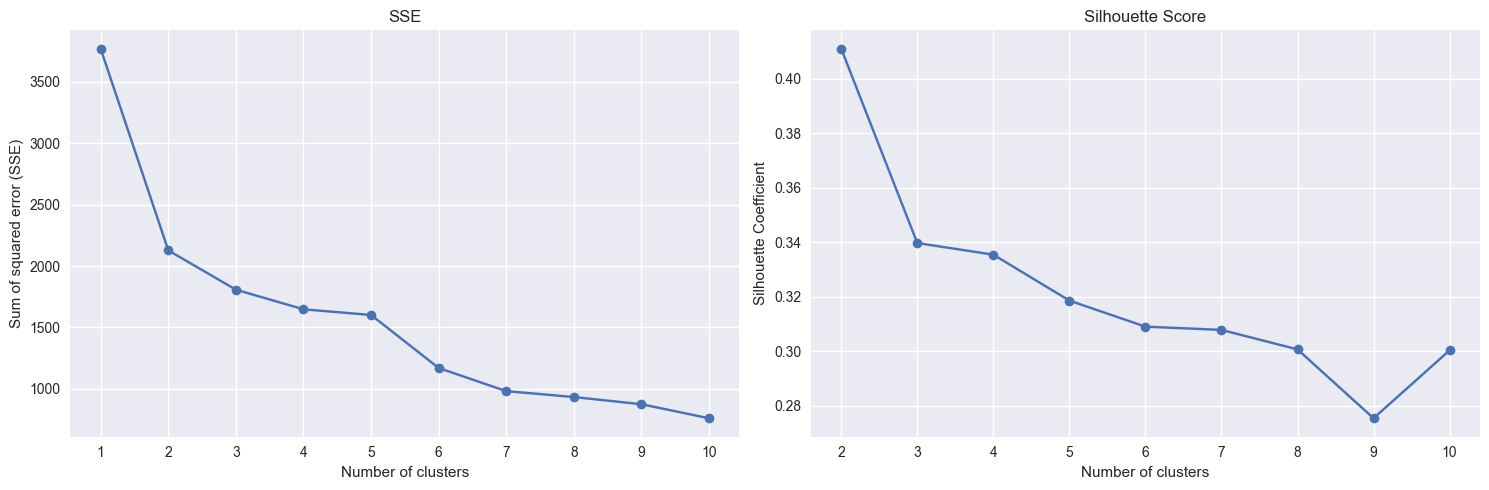

In [195]:
num_clusters = 10
gwp_sses = kmeans_elbow(X_gwp, num_clusters=num_clusters, seed=SEED)
gwp_silhouette_scores = kmeans_silhouette(X_gwp, num_clusters=num_clusters, seed=SEED)
plt.style.use('seaborn-v0_8')
plot_side_by_side(
    lambda: plot_cluster_sses(gwp_sses),
    lambda: plot_cluster_silhouettes(gwp_silhouette_scores),
    titles=["SSE", "Silhouette Score"],
)


#### KMeans Clustering with Dimensionality Reduction
Using two types of dimensionality reduction: 
- Principal Component Analysis (PCA), 
- t-distributed Stochastic Neighbor Embedding (t-SNE)

In [260]:


# Initialise Dimensionality reduction objects
gwp_pca = PCA(n_components=2, random_state=SEED)
gwp_tsne = TSNE(n_components=2, random_state=SEED)

# Fit data using both reduction methods
n_clusters = 2
pca_kmeans, X_gwp_pca = fit_kmean_cluster(X_gwp, gwp_pca, n_clusters, SEED)
tnse_kmeans, X_gwp_tsne = fit_kmean_cluster(X_gwp, gwp_tsne, n_clusters, SEED)

# Retrieve data
pca_gwp_data = get_cluster_data(pca_kmeans, X_gwp_pca)
tnse_gwp_data = get_cluster_data(tnse_kmeans, X_gwp_tsne)

print(f"PCA:  silhouette_score: {pca_gwp_data['silhouette']}")
print(f"TSNE: silhouette_score: {tnse_gwp_data['silhouette']}")

PCA:  silhouette_score: 0.595272409277829
TSNE: silhouette_score: 0.37894096970558167


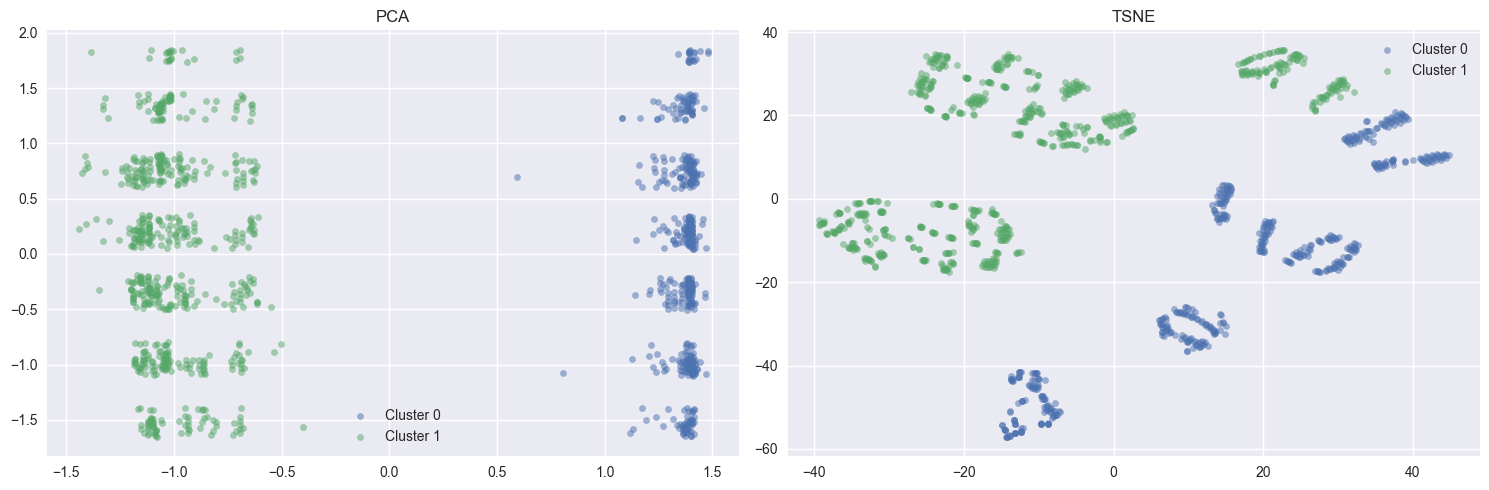

In [261]:
plot_side_by_side(
    lambda: plot_clusters(X_gwp_pca, pca_gwp_data['labels'], "Clustering results for GWP data"),
    lambda: plot_clusters(X_gwp_tsne, tnse_gwp_data['labels'], "Clustering results for GWP data (t-SNE)"),
    titles=["PCA", "TSNE"],
)

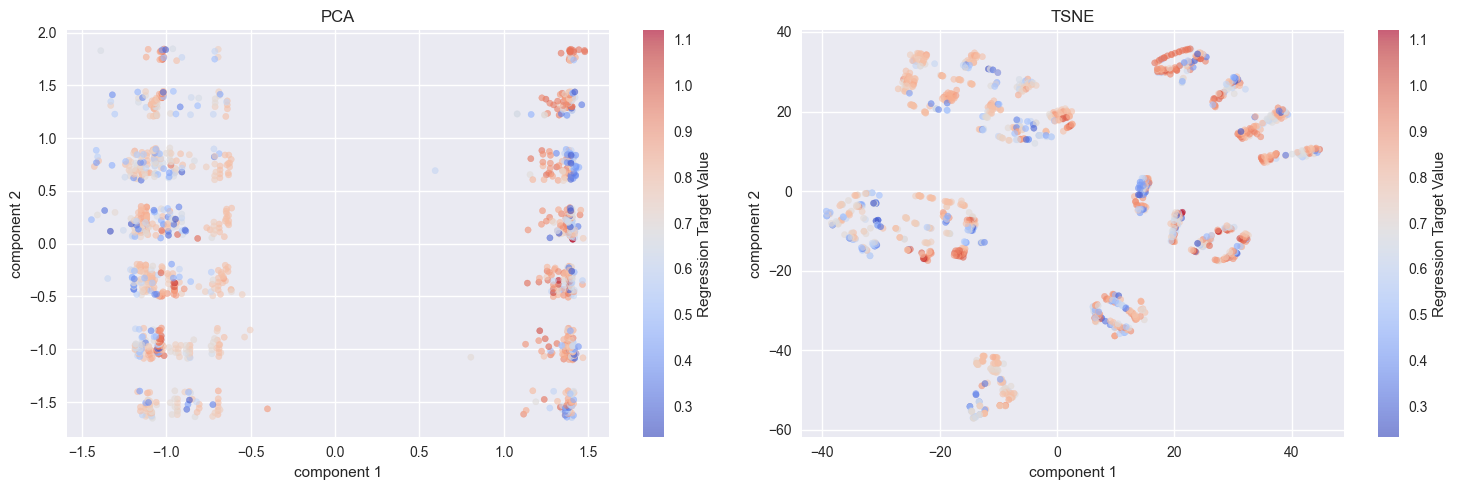

In [247]:
plot_side_by_side(
    lambda: plot_2d_data_heatscatter(X_gwp_pca, y_gwp),
    lambda: plot_2d_data_heatscatter(X_gwp_tsne, y_gwp),
    titles=["PCA", "TSNE"],
)

## Star Clustering

### K-means: Elbow method & Silhouette coefficient
<div class="warning">
    <strong>Warning:</strong> Cell running time upwards of 10 mins.
</div>

<style>
.warning {
    background-color: #ffeeba;
    border-color: #ffc107;
    color: #856404;
    padding: 1em;
    margin-top: 1em;
    margin-bottom: 1em;
    border: 1px solid transparent;
    border-radius: 0.25rem;
}
</style>


In [58]:
num_clusters = 10
star_sses = kmeans_elbow(X_star, num_clusters=num_clusters, seed=SEED)
star_silhouette_scores = kmeans_silhouette(X_star, num_clusters=num_clusters, seed=SEED)


From the plots below:
- "Elbow" point = 4 clusters.
- Highest coefficient point = 4 clusters

Optimum number of clusters for GWP data seems to be 4. 

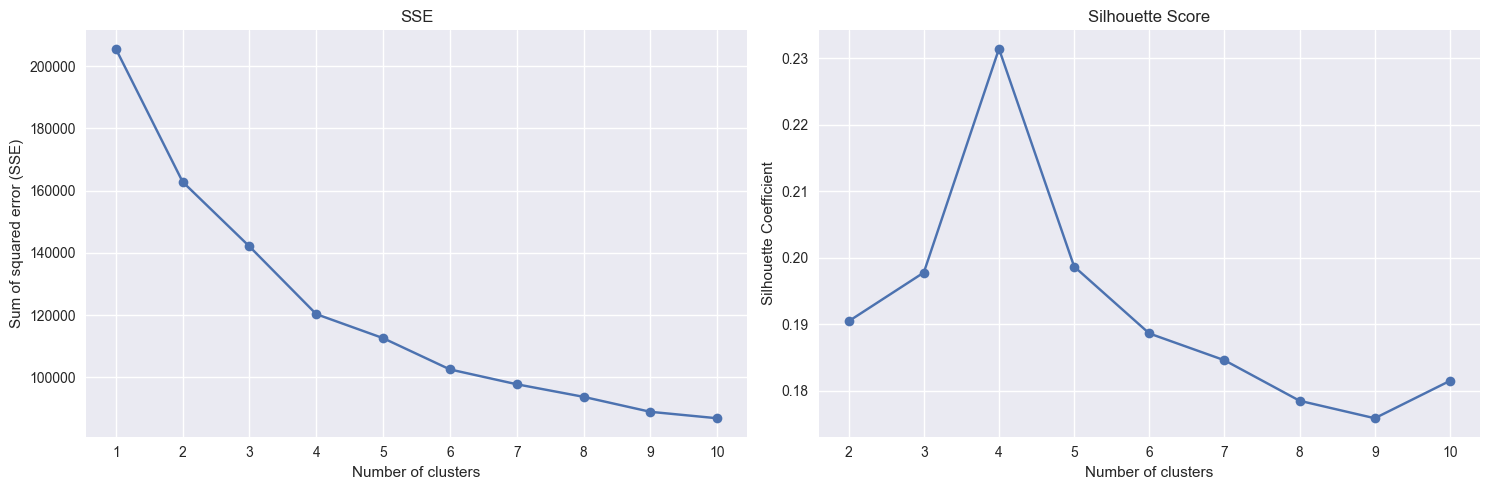

In [236]:
plot_side_by_side(
    lambda: plot_cluster_sses(star_sses),
    lambda: plot_cluster_silhouettes(star_silhouette_scores),
    titles=["SSE", "Silhouette Score"],
)

#### KMeans Clustering with Dimensionality Reduction
Since this is classification model, we will also calculate adjusted *Adjusted Rand Index (ARI)*.

ARI = similarity between the data labels and the labels predicted from clustering

#### PCA clustering & accuracy on predicted test set

In [ ]:
n_clusters = 3

# Initialise Dimensionality reduction object
star_pca = PCA(n_components=2, random_state=SEED)

# Fit data using both reduction methods
pca_star_kmeans, X_star_pca = fit_kmean_cluster(X_star_train, star_pca, n_clusters, SEED)
pca_star_data = get_cluster_data(pca_star_kmeans, X_star_pca, y_star_train)
print(f"PCA:  silhouette_score: {pca_star_data['silhouette']}, ari: {pca_star_data['ari']}")

In [310]:
# Accuracy on test set 
X_star_test_pca = star_pca.fit_transform(X_star_test)
accuracy = np.sum(pca_star_kmeans.predict(X_star_test_pca) == y_star_test) / y_star_test.size
print("Accuracy: ", accuracy)

Accuracy:  0.2242


#### t-SNE clustering & accuracy on predicted test set

In [305]:
n_clusters = 3

# Initialise Dimensionality reduction object
star_tsne = TSNE(n_components=2, random_state=SEED)

# Fit data using both reduction methods
tsne_star_kmeans, X_star_tsne = fit_kmean_cluster(X_star_train, star_tsne, n_clusters, SEED)
tsne_star_data = get_cluster_data(tsne_star_kmeans, X_star_tsne, y_star_train)

print(f"TSNE: silhouette_score: {tsne_star_data['silhouette']}, ari: {tsne_star_data['ari']}")

TSNE: silhouette_score: 0.37309321761131287, ari: 0.016023369613640474


In [311]:
# Accuracy on test set 
X_star_test_tsne = star_tsne.fit_transform(X_star_test)
accuracy = np.sum(tsne_star_kmeans.predict(X_star_test_tsne) == y_star_test) / y_star_test.size
print("Accuracy: ", accuracy)

Accuracy:  0.3911


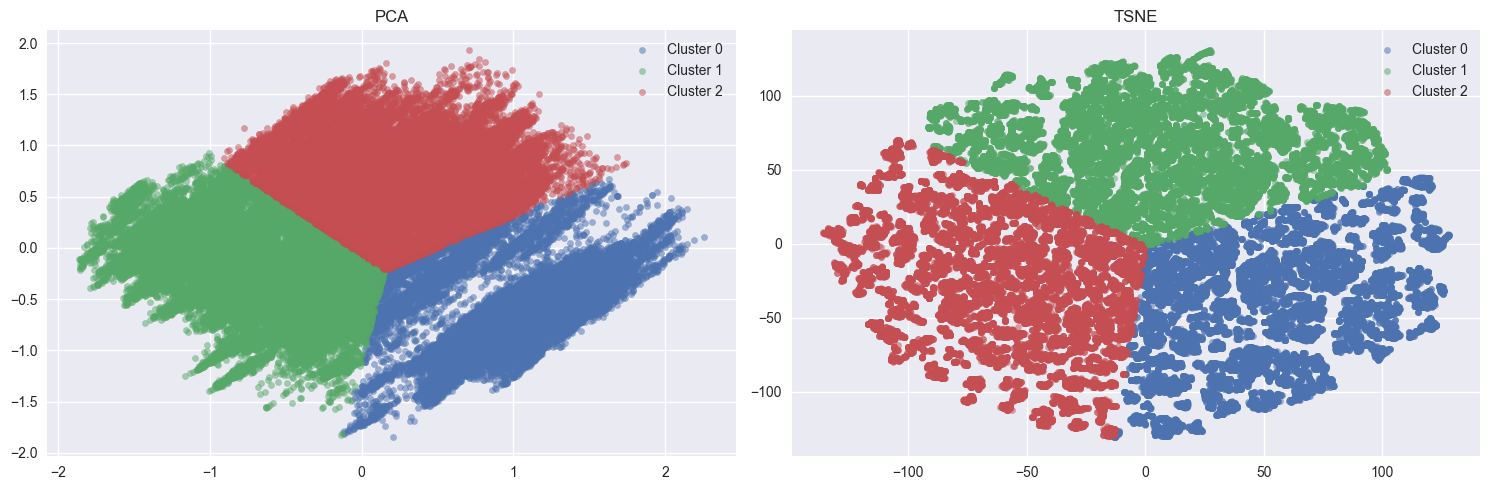

In [299]:
plot_side_by_side(
    lambda: plot_clusters(X_star_pca, pca_star_data['labels'], "Clustering results for STAR data"),
    lambda: plot_clusters(X_star_tsne, tsne_star_data['labels'], "Clustering results for STAR data (t-SNE)"),
    titles=["PCA", "TSNE"],
)

### Dimension Reduced Features shown in the colour of its true labels

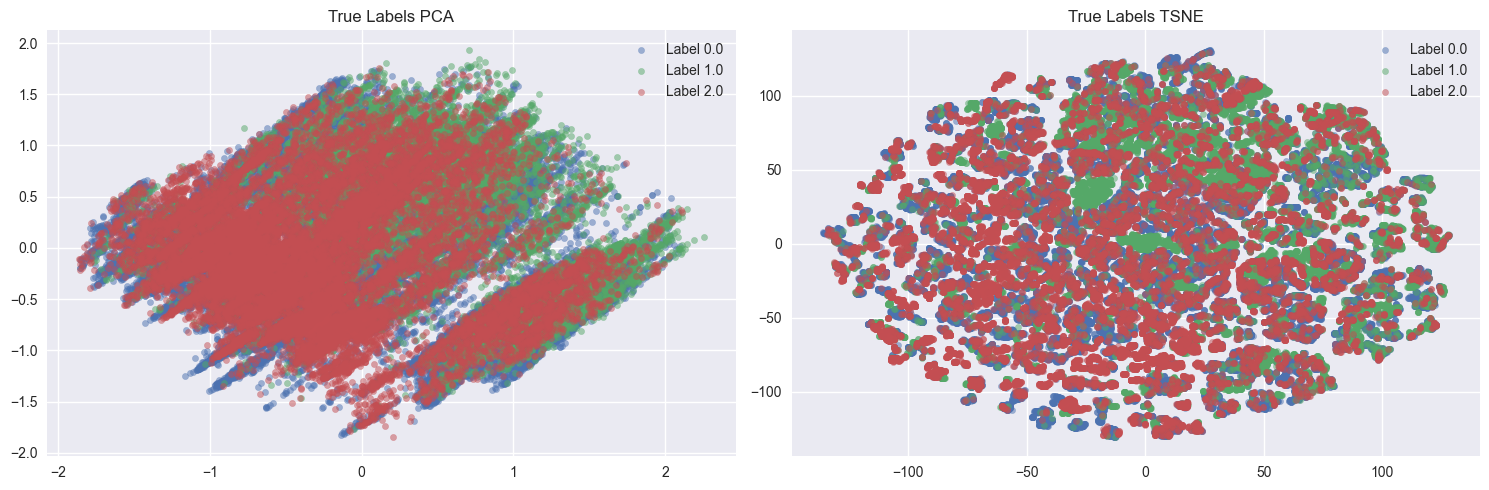

In [309]:
plot_side_by_side(
    lambda: plot_clusters(X_star_pca, y_star_train, "Clustering results for STAR data"),
    lambda: plot_clusters(X_star_tsne, y_star_train, "Clustering results for STAR data (t-SNE)"),
    titles=["True Labels PCA", "True Labels TSNE"],
)

#### Markdown Question: 
**Question**: Between clustering and classification algorithms, which one performed better for star dataset. Justify your answer.